<h1 style="text-align: center;">Evaluation results of IR and LLM Performances</h1>

## Downloading the IR and LLM evaluation results from drive

In [ ]:
! pip install gdown
! pip install git+https://github.com/giuliano-oliveira/gdown_folder.git

In [ ]:
import gdown
gdrive_folder_link = "https://drive.google.com/drive/folders/1pgUPmpIdepVifLUubNuT5mInsj2hkX3v"
gdown.download_folder(gdrive_folder_link)

## IR Evaluation Results

In [219]:
import json
import ijson
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

In [ ]:
def get_ir_scores(path):
    ir_scores = []
    with open(path, 'rb') as file:
        for all_scores in ijson.items(file, "all_scores"):
            for scores in all_scores :
                ir_scores.append([s[0] for s in scores[:10]])
    return ir_scores
    
ir_scores_bm25 = get_ir_scores(path = './evaluation_scores/ir_scores/scores_bm25.json')
ir_scores_sim = get_ir_scores(path = './evaluation_scores/ir_scores/scores_sim.json')
ir_scores_mmr = get_ir_scores(path = './evaluation_scores/ir_scores/scores_mmr.json')
ir_scores_mlq = get_ir_scores(path = './evaluation_scores/ir_scores/scores_mlq.json')
ir_scores_reo = get_ir_scores(path = './evaluation_scores/ir_scores/scores_reo.json')

ir_scores_list = [ir_scores_bm25, ir_scores_sim, ir_scores_mmr, ir_scores_mlq, ir_scores_reo]

In [41]:
def get_level_scores(scores):
    levels = [[] for _ in range(10)]
    for sublist in scores:
        for i, score in enumerate(sublist):
            levels[i].append(score)
    return levels

def average(ir_scores):
    return round(sum(ir_scores) / len(ir_scores), 2)

def get_average_level(levels):
    return [average(level) for level in levels]

all_avgs = [get_average_level(get_level_scores(ir_scores)) for ir_scores in ir_scores_list]

In [42]:
df = pd.DataFrame(all_avgs).T

# Assign column names
df.columns = ['avg_bm25', 'avg_sim', 'avg_mmr', 'avg_mlq', 'avg_reo']

# Create a new index
new_index = list(range(100, 1100, 100))
df.index = new_index

df

,avg_bm25,avg_sim,avg_mmr,avg_mlq,avg_reo
100,0.40,0.34,0.34,0.29,0.16
200,0.46,0.39,0.38,0.33,0.19
300,0.49,0.41,0.39,0.35,0.20
400,0.52,0.44,0.41,0.37,0.21
500,0.55,0.46,0.42,0.39,0.22
600,0.57,0.47,0.43,0.40,0.23
700,0.58,0.48,0.44,0.41,0.24
800,0.60,0.50,0.44,0.42,0.25
900,0.61,0.51,0.45,0.43,0.26
1000,0.62,0.52,0.46,0.43,0.26


# LLM Evaluation Results

In [265]:
with open("./evaluation_scores/llm_scores.json", 'r') as file:
    llm_scores = json.load(file)

In [112]:
def get_unique_col_counts(data):
    numpy_array = np.array([list(d.values()) for d in data])
    column_unique_counts = []
    for col_index in range(numpy_array.shape[1]):
        col = numpy_array[:, col_index]
        unique_elements, counts = np.unique(col, return_counts=True)
        total_sum = np.sum(counts)
        percentages =  np.round((counts / total_sum), 2)

        unique_counts_dict = dict(zip(unique_elements, percentages))
        column_unique_counts.append(unique_counts_dict)
    return column_unique_counts

unique_scores = get_unique_col_counts(llm_scores)

In [113]:
df = pd.DataFrame(unique_scores)
df.index = ['llm only', 'bm25', 'sim', 'mmr', 'reo', 'mlq']
df

,1,2,3,4,5
llm only,0.01,0.13,0.04,0.58,0.24
bm25,0.08,0.05,0.13,0.31,0.42
sim,0.09,0.05,0.14,0.40,0.32
mmr,0.10,0.07,0.12,0.42,0.29
reo,0.29,0.05,0.07,0.41,0.18
mlq,0.18,0.06,0.12,0.41,0.24


# Relationship between IR and LLM Evaluations

## 1. Plots sorted IR scores for specific LLM score values

In [114]:
def plot_ir_scores(ir_scores, llm_scores, ir="bm25", corres_llm_score=[1]):
    # Find indices where the corresponding LLM scores match the desired values
    i_scores = [i for i, scores in enumerate(llm_scores) if scores[ir] in corres_llm_score]
    
    # Extract the corresponding IR scores
    ir_scores_coress = [ir_scores[i][-1] for i in i_scores]
    
    plt.plot(sorted(ir_scores_coress))
    
    plt.xlabel('Index of example')
    plt.ylabel('IR score')
    plt.title(f'{ir.upper()} IR scores for LLM score in {corres_llm_score}')
    
    plt.show()

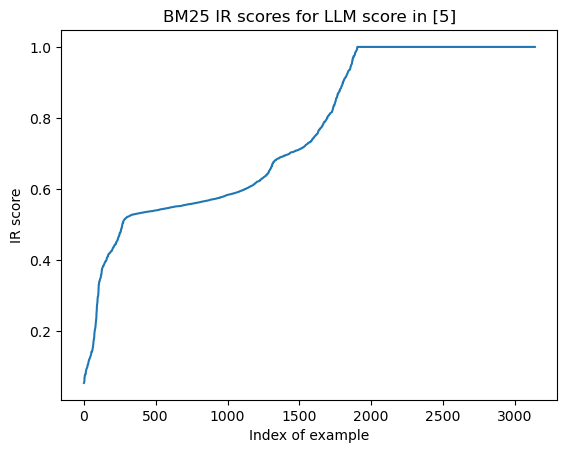

In [115]:
plot_ir_scores(ir_scores_bm25, llm_scores, ir="bm25", corres_llm_score=[5])

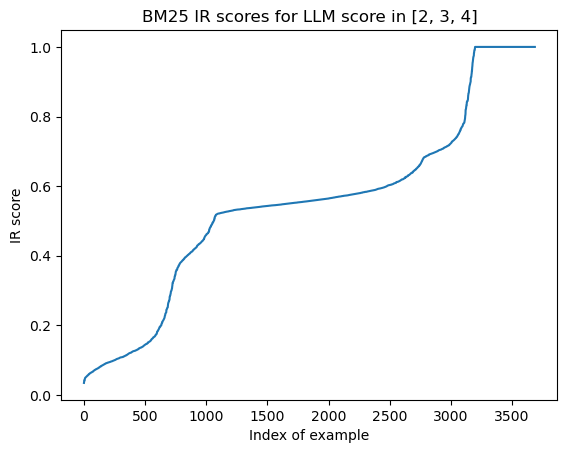

In [116]:
plot_ir_scores(ir_scores_bm25, llm_scores, ir="bm25", corres_llm_score=[2,3,4])

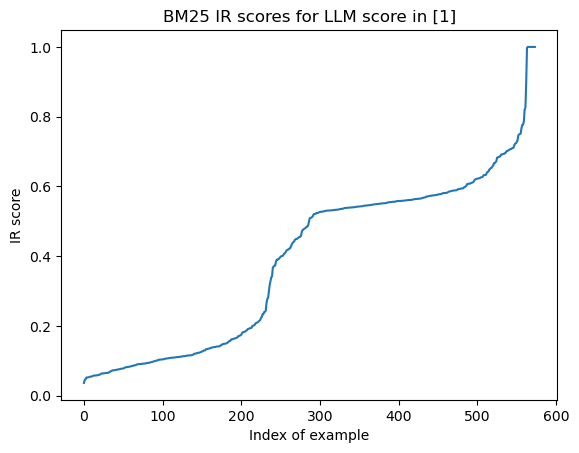

In [117]:
plot_ir_scores(ir_scores_bm25, llm_scores, ir="bm25", corres_llm_score=[1])

## 2. Estimation of Thresholds (h and k)

In [221]:
def get_ir_scores_1000(path = './evaluation_scores/ir_scores/scores_bm25.json'):
    scores_1000 = []
    with open(path, 'rb') as file:
        for all_scores in ijson.items(file, "all_scores"):
            for scores in all_scores :
                scores_1000.append(float(scores[:10][-1][0]))
    return scores_1000

all_ir_scores = (get_ir_scores_1000(path='./evaluation_scores/ir_scores/scores_bm25.json') + 
                 get_ir_scores_1000(path='./evaluation_scores/ir_scores/scores_sim.json') +
                 get_ir_scores_1000(path='./evaluation_scores/ir_scores/scores_mmr.json') +
                 get_ir_scores_1000(path='./evaluation_scores/ir_scores/scores_reo.json') +
                 get_ir_scores_1000(path='./evaluation_scores/ir_scores/scores_mlq.json')
                 )
values_dict = {key: [] for key in llm_scores[0] if key != 'llm_only'}
for score in llm_scores:
    for key in values_dict:
        values_dict[key].append(score[key])

all_llm_scores = [value for values in values_dict.values() for value in values]

In [ ]:
def likelihood_function_k(k, ir_scores, llm_scores, llm_score=5):
    # Convert lists to NumPy arrays
    ir_scores = np.array(ir_scores)
    llm_scores = np.array(llm_scores)
    
    # Perform element-wise comparisons
    p_ir = (ir_scores <= k).astype(int)
    p_llm = (llm_scores == llm_score).astype(int)
    
    # Calculate likelihoods
    likelihoods = p_ir * p_llm + (1 - p_ir) * (1 - p_llm)
    
    return np.sum(np.log(likelihoods + 1e-10))  # return negative for minimization

def likelihood_function_h(k, ir_scores, llm_scores, llm_score=5):
    # Convert lists to NumPy arrays
    ir_scores = np.array(ir_scores)
    llm_scores = np.array(llm_scores)
    
    # Perform element-wise comparisons
    p_ir = (ir_scores >= k).astype(int)
    p_llm = (llm_scores == llm_score).astype(int)
    
    # Calculate likelihoods
    likelihoods = p_ir * p_llm + (1 - p_ir) * (1 - p_llm)
    
    return np.sum(np.log(likelihoods + 1e-10))  # return negative for minimization

def find_best_k(ir_scores, llm_scores, llm_score=5, bounds=(0, 1)):
    result = differential_evolution(likelihood_function_k, bounds=[bounds], args=(ir_scores, llm_scores, llm_score))
    return round(result.x[0],2)

def find_best_h(ir_scores, llm_scores, llm_score=5, bounds=(0, 1)):
    result = differential_evolution(likelihood_function_h, bounds=[bounds], args=(ir_scores, llm_scores, llm_score))
    return round(result.x[0],2)

best_k = find_best_k(all_ir_scores, all_llm_scores, llm_score=5)
best_h = find_best_h(all_ir_scores, all_llm_scores, llm_score=1)

## 3. Plots sorted IR scores with thresholds h and k

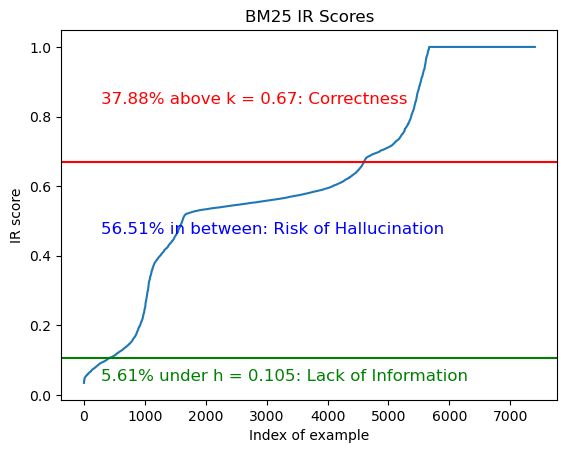

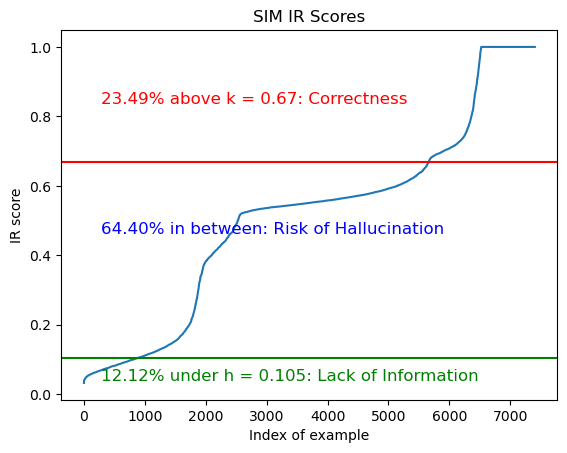

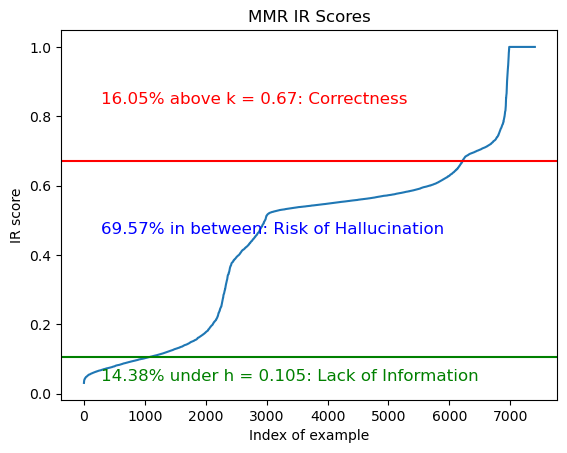

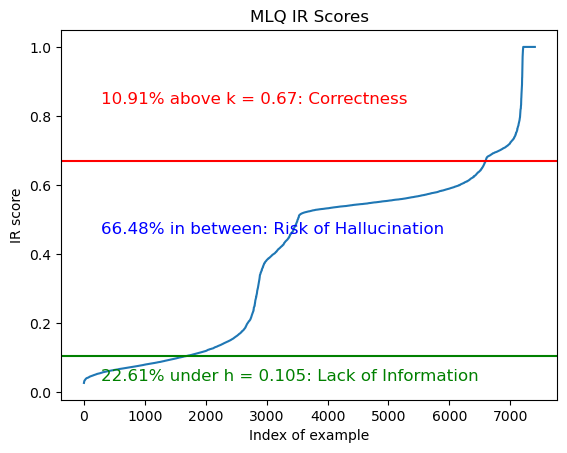

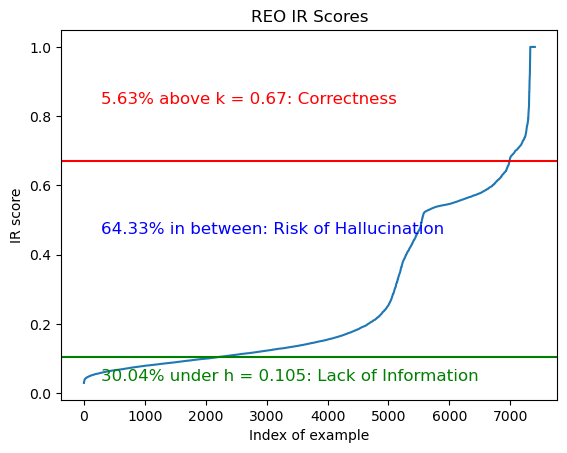

In [232]:
def plot_estimation(ir_scores_ret=ir_scores_bm25, k= best_k, h= best_h, title='IR scores'):
    # Extract the last IR scores
    ir_scores = [ir_score[-1] for ir_score in ir_scores_ret]
    sorted_scores = sorted(ir_scores)
    
    # Calculate percentages
    percentage_above_k = (sum(score > k for score in ir_scores) / len(ir_scores)) * 100
    percentage_under_h = (sum(score < h for score in ir_scores) / len(ir_scores)) * 100
    percentage_between_ks = (sum(h <= score <= k for score in ir_scores) / len(ir_scores)) * 100
    
    # Plotting
    plt.plot(sorted_scores)
    plt.axhline(y=k, color='red', linestyle='-')
    plt.axhline(y=h, color='green', linestyle='-')
    
    # Display the percentage on the plot
    plt.text(0.08, 0.8, f'{percentage_above_k:.2f}% above k = {k}: Correctness', color='red', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.08, 0.05, f'{percentage_under_h:.2f}% under h = {h}: Lack of Information', color='green', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.08, 0.45, f'{percentage_between_ks:.2f}% in between: Risk of Hallucination', color='blue', fontsize=12, transform=plt.gca().transAxes)
    
    plt.xlabel('Index of example')
    plt.ylabel('IR score')
    plt.title(title)
    
    plt.show()

plot_estimation(ir_scores_ret=ir_scores_bm25, title='BM25 IR Scores')
plot_estimation(ir_scores_ret=ir_scores_sim, title='SIM IR Scores')
plot_estimation(ir_scores_ret=ir_scores_mmr, title='MMR IR Scores')
plot_estimation(ir_scores_ret=ir_scores_mlq, title='MLQ IR Scores')
plot_estimation(ir_scores_ret=ir_scores_reo, title='REO IR Scores')